In [72]:
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
# use matplotlib to show cv2_read_img
def show_img(img, winname='figure1'):
    plt.figure()
    if len(img.shape)==3 and img.shape[2] == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(winname)
    plt.show()

uint8 (224, 224, 3)


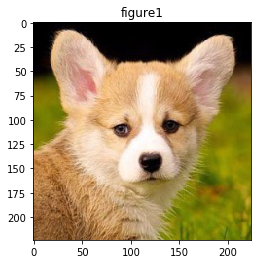

In [21]:
img = cv2.imread('./img/dog.jpg', 1)
print(img.dtype, img.shape)
show_img(img)

In [112]:
# color  change
def random_change_color(img, rang=50):
    b, g, r = cv2.split(img)
    for ch in [b, g, r]:
        rand = random.randint(-rang, rang)
        if rand == 0:
            pass
        elif rand > 0:
            lim = 255 - rand
            ch[ch>lim] = 255
            ch[ch<=lim] = (rand + ch[ch<=lim]).astype(img.dtype)
        elif rand < 0:
            lim = 0 - rand 
            ch[ch<lim] = 0
            ch[ch>=lim] = (rand + ch[ch>=lim]).astype(img.dtype)
    img_merge = cv2.merge([b, g, r])
    return img_merge

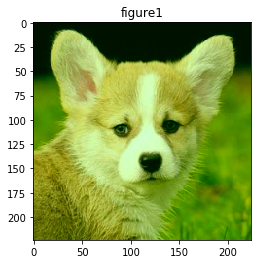

In [114]:
img = cv2.imread('./img/dog.jpg', 1)
img_random_color = random_change_color(img,80)
show_img(img_random_color)

#### gamma变换
$s = cr^{\gamma}$  
gamma<1时，拉伸图像中低灰度级部分，压缩高灰度级部分  
gamma>1时，压缩图像中低灰度级部分，拉伸高灰度级部分  
gamma=c=1时，简化成了恒等变换

In [9]:
def gamma_correction(image, gamma=1.0):
    if not gamma>0.0:
        raise ValueError('gamma should be greater than 0')
    inv_gamma = 1.0/gamma
    table = []
    for i in range(256):
        table.append(((i/255.0) ** inv_gamma) * 255)
    table = np.array(table).astype('uint8')
    return cv2.LUT(image, table)
"""
cv2.LUT(src,lut[,dst]):look up in table(查表操作)
src:input array of 8-bit elements.
lut:look-up table of 256 elements; in case of multi-channel input array, the table should either have a single channel 
or the same number of channels as in the input array.
dst:output array of the same size and number of channels as src, and the same depth as lut.

"""

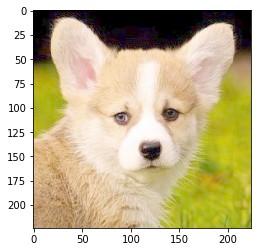

In [10]:
img = cv2.imread('./img/dog.jpg', 1)
img_gamma = gamma_correction(img, 2)
show_img(img_gamma)

#### 直方图均衡
直方图：图像灰度值的概率分布（概率密度函数）$p(r_k) = \frac{n_k}{MN}$  
直方图均衡：使变换后的图像的直方图尽量平坦均衡为一个常数$s_k = T(r_k) = (L-1)\sum_{j=0}^{n}p(r_k)$  
s为变换后的像素值，r为变换前的像素值

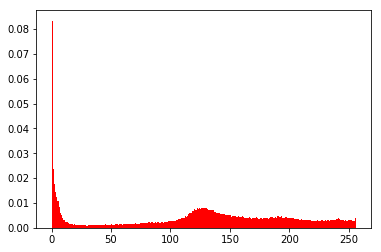

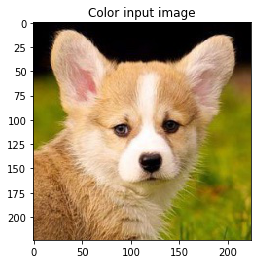

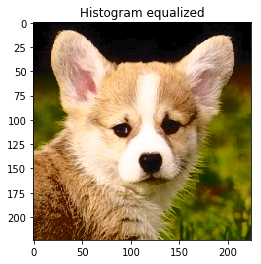

In [47]:
# histogram
img = cv2.imread('./img/dog.jpg', 1)
plt.hist(img.flatten(), bins=256, range=[0, 256], density=True, color = 'r')
"""
plt.hist():显示直方图
bins：条形数（int），range:x轴范围，density:是否以密度形式显示 
"""
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])   # only for 1 channel
# convert the YUV image back to RGB format
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)   
# cv2.imshow('Color input image', img)
# cv2.imshow('Histogram equalized', img_output)
show_img(img, 'Color input image')
show_img(img_output, 'Histogram equalized')

#### Similarity Transform = Rotation + Translation +Scale(旋转+平移+缩放)
保持四边平行和四个直角不变

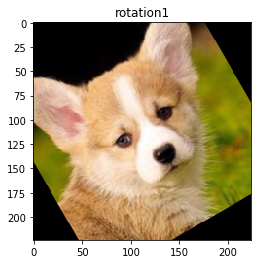

[[  0.8660254    0.5        -40.99484522]
 [ -0.5          0.8660254   71.00515478]]


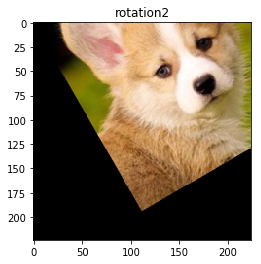

[[ 0.8660254  0.5        0.       ]
 [-0.5        0.8660254  0.       ]]


In [84]:
### rotation
img = cv2.imread('./img/dog.jpg', 1)
rot_mat = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), 30, 1)#center,angle,scale
# 仿射变换,(img.shape[1],img.shape[0])表示变换后显示图片大小
img_rotate = cv2.warpAffine(img, rot_mat, (int(img.shape[1]),img.shape[0]))
show_img(img_rotate, 'rotation1')
print(rot_mat)

rot_mat[0,2] = rot_mat[1,2] = 0 # rot_mat[:,2]表示以图像[0,0]为中心旋转后的平移量
img_rotate = cv2.warpAffine(img, rot_mat, (int(img.shape[1]),img.shape[0]))
show_img(img_rotate, 'rotation2')
print(rot_mat)

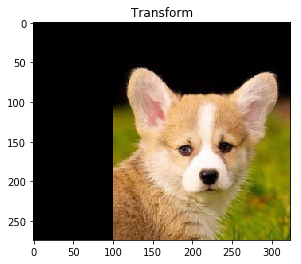

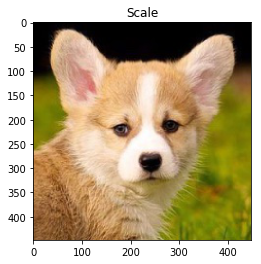

In [86]:
# 平移
mat = np.array([[1,0,100],
                [0,1,50]], dtype=np.float32)

img_tran = cv2.warpAffine(img, mat, (img.shape[1]+100, img.shape[0]+50))
show_img(img_tran, 'Transform')
# scale
mat = cv2.getRotationMatrix2D((0,0), 0, 2)
img_scale = cv2.warpAffine(img, mat, (img.shape[1]*2, img.shape[0]*2))
show_img(img_scale, 'Scale')

#### Affine Transform(仿射变换)
保持四边平行

[[ 1.39516129 -0.22421525 50.        ]
 [-0.16129032  0.9103139  20.        ]]


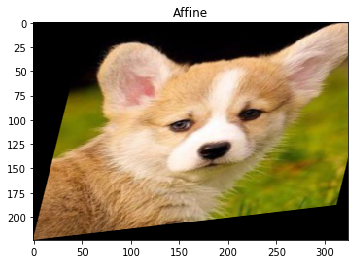

In [110]:
img = cv2.imread('./img/dog.jpg', 1)
rows, cols, ch = img.shape
pts1 = np.float32([[0,0], [cols-100, 0], [0, rows-1]])
pts2 = np.float32([[50, 20], [cols-1,0], [0,rows-1]])
mat = cv2.getAffineTransform(pts1, pts2)
dst = cv2.warpAffine(img, mat, (cols+100, rows))
print(mat)
show_img(dst, 'Affine')

#### Perspective Transform(投影变换)
四个边和四个角任意变换

In [96]:
def random_warp(img, row, col):
    height, width, channels = img.shape

    # warp:
    random_margin = 60
    x1 = random.randint(-random_margin, random_margin) 
    y1 = random.randint(-random_margin, random_margin) 
    x2 = random.randint(width - random_margin - 1, width - 1)
    y2 = random.randint(-random_margin, random_margin)
    x3 = random.randint(width - random_margin - 1, width - 1)
    y3 = random.randint(height - random_margin - 1, height - 1)
    x4 = random.randint(-random_margin, random_margin)
    y4 = random.randint(height - random_margin - 1, height - 1)

    dx1 = random.randint(-random_margin, random_margin)
    dy1 = random.randint(-random_margin, random_margin)
    dx2 = random.randint(width - random_margin - 1, width - 1)
    dy2 = random.randint(-random_margin, random_margin)
    dx3 = random.randint(width - random_margin - 1, width - 1)
    dy3 = random.randint(height - random_margin - 1, height - 1)
    dx4 = random.randint(-random_margin, random_margin)
    dy4 = random.randint(height - random_margin - 1, height - 1)

    pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    pts2 = np.float32([[dx1, dy1], [dx2, dy2], [dx3, dy3], [dx4, dy4]])
    M_warp = cv2.getPerspectiveTransform(pts1, pts2)
    img_warp = cv2.warpPerspective(img, M_warp, (width, height))
    return M_warp, img_warp


[[ 1.43684518e+00 -2.84676385e-01 -4.66597371e+01]
 [ 1.58151856e-01  6.42813958e-01 -1.36634989e+01]
 [ 7.12847549e-04 -1.98342236e-03  1.00000000e+00]]


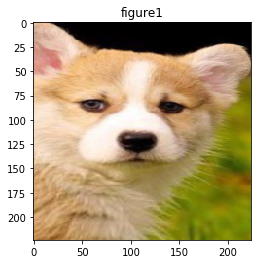

In [111]:
M_warp, img_warp = random_warp(img, img.shape[0], img.shape[1])
print(M_warp)
show_img(img_warp)